# A New Stellar Mass Proxy for Subhalo Abundance Matching
## Load TNG300 Data

In [1]:
### Import Libraries ###
import os, sys
import numpy as np
import pandas as pd
import pickle
import h5py

from astropy.cosmology import FlatLambdaCDM
from scipy import stats as st

import illustris_python as il
import multiprocessing
from multiprocessing import Process
from Corrfunc.theory.wp import wp

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'axes.facecolor': (1.0, 1.0, 1.0, 0.0), 'figure.facecolor':  (1.0, 0.0, 0.0, 0.0)})


In [4]:
### Constants ###
h = 0.6774

Box_dict = {'300':300, '100':111, '50':52}
Res_dict = {'300': [5.9e7, 1.1e7], '100': [7.5e6, 1.4e6], '50': [4.5e5, 8.5e4]}
SnapAge = np.array([0.179, 0.271, 0.37, 0.418, 0.475, 0.517, 0.547, 0.596, 0.64, 0.687, 0.732, 0.764, 0.844, 0.932, 0.965, 1.036, 1.112, 1.177, 1.282, 1.366, 1.466, 1.54, 1.689, 1.812, 1.944, 2.145, 2.238, 2.384, 2.539, 2.685, 2.839, 2.981, 3.129, 3.285, 3.447, 3.593, 3.744, 3.902, 4.038, 4.206, 4.293, 4.502, 4.657, 4.816, 4.98, 5.115, 5.289, 5.431, 5.577, 5.726, 5.878, 6.073, 6.193, 6.356, 6.522, 6.692, 6.822, 6.998, 7.132, 7.314, 7.453, 7.642, 7.786, 7.932, 8.079, 8.28, 8.432, 8.587, 8.743, 8.902, 9.062, 9.225, 9.389, 9.556, 9.724, 9.837, 10.009, 10.182, 10.299, 10.535, 10.654, 10.834, 11.016, 11.138, 11.323, 11.509, 11.635, 11.824, 11.951, 12.143, 12.337, 12.467, 12.663, 12.795, 12.993, 13.127, 13.328, 13.463, 13.667, 13.803])
redshift_arr = np.array([20.05, 14.99, 11.98, 10.98, 10, 9.39, 9, 8.45, 8.01, 7.6, 7.24, 7.01, 6.49, 6.01, 5.85, 5.53, 5.23, 5, 4.66, 4.43, 4.18, 4.01, 3.71, 3.49, 3.28, 3.01, 2.9, 2.73, 2.58, 2.44, 2.32, 2.21, 2.1, 2, 1.9, 1.82, 1.74, 1.67, 1.6, 1.53, 1.5, 1.41, 1.36, 1.3, 1.25, 1.21, 1.15, 1.11, 1.07, 1.04, 1, 0.95, 0.92, 0.89, 0.85, 0.82, 0.79, 0.76, 0.73, 0.7, 0.68, 0.64, 0.62, 0.6, 0.58, 0.55, 0.52, 0.5, 0.48, 0.46, 0.44, 0.42, 0.4, 0.38, 0.36, 0.35, 0.33, 0.31, 0.3, 0.27, 0.26, 0.24, 0.23, 0.21, 0.2, 0.18, 0.17, 0.15, 0.14, 0.13, 0.11, 0.1, 0.08, 0.07, 0.06, 0.05, 0.03, 0.02, 0.01, 0])

### Variables ###
TNG_ver = '300'
snap_num = 99
z = redshift_arr[snap_num]
mass_lim = 0.0

# The original SDSS photometry for snapshot 33 is in apparent magnitude, you need this to convert it to absolute magnitude.
# Please skip this if you're not working with snapshot 33
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
DL = cosmo.luminosity_distance(z).value*1e6

### Directory for out put files ###
outdir = './outdir'
if not os.path.isdir(outdir):
    os.system('mkdir '+outdir)

In [5]:
### Load the raw data ###
# hydro part
basePath = './TNG'+TNG_ver+'-1/output/'
subhalos = il.groupcat.loadSubhalos(basePath, snap_num)
grouphalos = il.groupcat.loadHalos(basePath,snap_num)

# dark matter only part
basePath_D = './TNG'+TNG_ver+'-1-Dark/output/'
subhalos_D = il.groupcat.loadSubhalos(basePath_D, snap_num)
grouphalos_D = il.groupcat.loadHalos(basePath_D,snap_num)

# Subhalo matching index
HDmatch = h5py.File('./TNG'+TNG_ver+'-1/files/subhalo_matching_to_dark.hdf5')

# SDSS photometry
SDSS_phot_fl = h5py.File('./TNG'+TNG_ver+'-1/files/SDSS/Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc_0'+str(snap_num)+'.hdf5', 'r')


In [6]:
### Load Subhalo Hydro Features ###
## Subfind ID ##
# Please uncomment section below #
subfind_ID = np.array(range(subhalos['count']))
#SubhaloIndex_TNG = np.array(LGalaxies['Galaxy/SubhaloIndex_TNG'])
ele, pos1, pos2 = np.intersect1d(subfind_ID, subfind_ID, return_indices=True) #np.intersect1d(subfind_ID, SubhaloIndex_TNG, return_indices=True)
subfind_ID = subfind_ID[pos1]
#SubhaloIndex_TNG = SubhaloIndex_TNG[pos2]

## Hydro Features ##
SubhaloFlag = np.array(subhalos['SubhaloFlag'])[pos1]
SubhaloMassType = np.array(subhalos['SubhaloMassType'])[pos1] * 1e10 / h
SubhaloPos = np.array(subhalos['SubhaloPos'])[pos1] * 1000.0/h
SDSS_phot = np.array(SDSS_phot_fl['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc'])[pos1,:,0]-5*np.log10(h)
if snap_num == 33:
    SDSS_phot = SDSS_phot-5*np.log10(DL/10) # (only snapshot 33) Convert to absolute magnitude
SubhaloMatchID = np.array(HDmatch['Snapshot_'+str(snap_num)]['SubhaloIndexDark_LHaloTree']) # Match IDs for DMO simulation

SubhaloFeat_H = [
    SubhaloMassType[:,4],
    SDSS_phot,
    SubhaloMatchID,
    subfind_ID,
    SubhaloPos
]

## Galaxy selection criteria ##
match_flag = SubhaloMatchID != -1
mass_flag = SubhaloMassType[:,4]>=1e9/h
flag_ID = np.where(np.logical_and(np.logical_and(mass_flag, match_flag), SubhaloFlag!=0))

SubhaloFeat_H_1 = []
for i in range(len(SubhaloFeat_H)):
    SubhaloFeat_H_1.append(SubhaloFeat_H[i][flag_ID])

### Load Subhalo Drak Matter Features ###
subfind_ID_D = np.array(range(subhalos_D['count']))
SubhaloMass_D = np.array(subhalos_D['SubhaloMass']) * 1e10 / h
SubhaloMassType_D = np.array(subhalos_D['SubhaloMassType']) * 1e10 / h
SubhaloVmax_D = np.array(subhalos_D['SubhaloVmax'])
SubhaloPos_D = np.array(subhalos_D['SubhaloPos']) * 1000.0/h
SubhaloHalfmassRad_D = np.array(subhalos_D['SubhaloHalfmassRad']) * 1000.0/h
SubhaloVmaxRad_D = np.array(subhalos_D['SubhaloVmaxRad']) * 1000.0/h
SubhaloMassInMaxRad_D = np.array(subhalos_D['SubhaloMassInMaxRad']) * 1e10 / h
SubhaloVelDisp_D = np.array(subhalos_D['SubhaloVelDisp'])
SubhaloSpin_D = np.array(subhalos_D['SubhaloSpin'])
SubhaloCM_D = np.array(subhalos_D['SubhaloCM']) * 1000.0/h
SubhaloGrNr_D = np.array(subhalos_D['SubhaloGrNr'])
GroupFirstSub_D = np.array(grouphalos_D['GroupFirstSub'])[SubhaloGrNr_D]
SubhaloCent_D = np.array(subfind_ID_D == GroupFirstSub_D, dtype=np.float64)

SubhaloFeat_D = [
    SubhaloMass_D,
    SubhaloMassType_D[:,1],
    SubhaloVmax_D,
    SubhaloVelDisp_D,
    SubhaloHalfmassRad_D,
    SubhaloVmaxRad_D,
    SubhaloMassInMaxRad_D,
    SubhaloPos_D,
    SubhaloCM_D,
    SubhaloSpin_D,
    SubhaloCent_D,
    subfind_ID_D
]

SubhaloFeat_D_1 = []
for i in range(len(SubhaloFeat_D)):
    SubhaloFeat_D_1.append(SubhaloFeat_D[i][SubhaloFeat_H_1[2]])

## Subhalo selection criteria ##
flag_D = SubhaloFeat_D_1[1]>=1e11/h

SubhaloFeat_H_2 = []
for i in range(len(SubhaloFeat_H_1)):
    SubhaloFeat_H_2.append(SubhaloFeat_H_1[i][flag_D])

SubhaloFeat_D_2 = []
for i in range(len(SubhaloFeat_D_1)):
    SubhaloFeat_D_2.append(SubhaloFeat_D_1[i][flag_D])

## Number of Central/Satellite galaxies ##
print('Total #: ', len(SubhaloFeat_D_2[-1]))
print('Central #: ', len(SubhaloFeat_D_2[-1][SubhaloFeat_D_2[-2].astype(bool)]), ', Satellite #:', len(SubhaloFeat_D_2[-1][~SubhaloFeat_D_2[-2].astype(bool)]))



Total #:  178145
Central #:  137436 , Satellite #: 40709


In [7]:
### Parallel Load History Features ###
Trunk_base = il.sublink.loadTree(basePath_D, snap_num, 0, onlyMPB=True)
Trunk_base_H = il.sublink.loadTree(basePath_D, snap_num, 0, onlyMPB=True)

def retrieve_features(arr_num, # thread id
                      subfind_arrs, # subfind id assigned to this thread
                      Treefeatures_dict, # main dictionary
                      subfindid): # (debug) confirm the actually loaded subhalos
    tree_keys = np.array(Treefeatures_dict.keys())
    axcl_keys = []
    hydro_keys = []
    ref = np.arange(99, -1, -1)
    tree_features = {}
    hydro_flag = 0
    
    ## Split hydro history keys##
    for key in tree_keys:
        if key[-1] == 'H':
            hydro_flag = 1
            tree_keys = np.delete(tree_keys, np.where(tree_keys == key))
            hydro_keys.append(key[:-2])
            if len(Trunk_base_H[key[:-2]].shape) == 1:
                shp = (1, 100)
            elif len(Trunk_base_H[key[:-2]].shape) == 2:
                shp = (1, 100, Trunk_base_H[key[:-2]].shape[-1])
            tree_features[key] = np.empty(shp, np.float64)
            continue
        if len(Trunk_base[key].shape) == 1:
            shp = (1, 100)
        elif len(Trunk_base[key].shape) == 2:
            shp = (1, 100, Trunk_base[key].shape[-1])
        tree_features[key] = np.empty(shp, np.float64)
    
    ## Load history of each subhalo ##
    ttsubfind_arr = []
    for i in range(len(subfind_arrs)):
        # Initialize empty dictionary #
        base_dict = {}
        Trunk = il.sublink.loadTree(basePath_D, snap_num, subfind_arrs[i], onlyMPB=True)
        if hydro_flag == 1:
            Trunk_H = il.sublink.loadTree(basePath_D, snap_num, subfind_arrs[i], onlyMPB=True)
        if Trunk == None:
            ele, pos1, pos2 = np.intersect1d(ref, ref, return_indices=True)
        else:
            ele, pos1, pos2 = np.intersect1d(ref, Trunk['SnapNum'], return_indices=True)
        
        # Load DM history #
        for key in tree_keys:
            if len(Trunk[key].shape) == 2:
                base_dict[key] = np.empty((100, Trunk[key].shape[-1]))
                base_dict[key][:, :] = np.NaN
                if Trunk == None:
                    continue
                base_dict[key][pos1] = Trunk[key][pos2]
                continue
            base_dict[key] = np.empty(100)
            base_dict[key][:] = np.NaN
            if Trunk == None:
                continue
            base_dict[key][pos1] = Trunk[key][pos2]
        
        # Load Hydro history #
        for key in hydro_keys:
            if len(Trunk[key].shape) == 2:
                ele_h, pos1_h, pos2_h = np.intersect1d(Trunk['SnapNum'], Trunk_H['SnapNum'], return_indices=True)
                ele_t, pos1_o, pos2_o = np.intersect1d(pos2, pos1_h, return_indices=True)
                
                base_dict[key+'_H'] = np.empty((100, Trunk[key].shape[-1]))
                base_dict[key+'_H'][:, :] = np.NaN
                if Trunk == None or Trunk_H == None:
                    continue
                base_dict[key+'_H'][pos1[pos1_o]] = Trunk[key][pos2_h[pos2_o]]
                continue
            ele_h, pos1_h, pos2_h = np.intersect1d(Trunk['SnapNum'], Trunk_H['SnapNum'], return_indices=True)
            ele_t, pos1_o, pos2_o = np.intersect1d(pos2, pos1_h, return_indices=True)
            
            base_dict[key+'_H'] = np.empty(100)
            base_dict[key+'_H'][:] = np.NaN
            if Trunk == None or Trunk_H == None:
                continue
            base_dict[key+'_H'][pos1[pos1_o]] = Trunk[key][pos2_h[pos2_o]]
        
        if i%1000 == 1 and arr_num == 0:
            print(i)
        
        # Load the features to the main dictionary #
        for key in list(tree_features.keys()):
            tree_features[key] = np.append(tree_features[key], np.array([base_dict[key]]), axis=0)
        ttsubfind_arr.append(subfind_arrs[i])
    subfindid[arr_num] = ttsubfind_arr
    
    for key in list(tree_features.keys()):
        Treefeatures_dict[key][arr_num] = tree_features[key][1:]


# History features (add _H for features in hydro simulation
Tree_keys = [
    'SnapNum', 
    'SubhaloMass',
    'SubhaloMassType',
    'SubhaloVmax',
    'SubhaloVelDisp',
    'SubhaloHalfmassRad',
    'SubhaloVmaxRad',
    'SubhaloMassInMaxRad',
    'SubhaloPos',
    'SubhaloCM',
    'SubhaloSpin',
    'Group_M_Crit200'
]

## Parallel ##
global Treefeatures_dict
global subfindid

subfind_ID_1_multi = np.array_split(SubhaloFeat_D_2[-1], 64) # 64 threads
processes = []
manager = multiprocessing.Manager()
Treefeatures_dict = manager.dict()
subfindid = manager.dict()
for key in Tree_keys:
    Treefeatures_dict[key] = manager.dict()

for i in range(len(subfind_ID_1_multi)):
    p = Process(target=retrieve_features, args=(i, subfind_ID_1_multi[i], Treefeatures_dict, subfindid))
    processes.append(p)
    p.start()
for p in processes:
    p.join()

## Load data from individual threads ##
for key in Treefeatures_dict.keys():
    tmp2 = Treefeatures_dict[key][0]
    for i in range(1, len(subfind_ID_1_multi)):
        tmp2 = np.concatenate((tmp2, Treefeatures_dict[key][i]), axis=0)
    Treefeatures_dict[key] = tmp2
    print(Treefeatures_dict[key].shape)
Treefeatures_dict = dict(Treefeatures_dict)

tmp3 = subfindid[0]
for i in range(1, len(subfind_ID_1_multi)):
    tmp3 = np.concatenate((tmp3, subfindid[i]), axis=0)


TreeSnapNum_D = np.array(np.flip(Treefeatures_dict['SnapNum'], axis=1), dtype=int)
TreeSubhaloMass_D = np.flip(Treefeatures_dict['SubhaloMass'], axis=1)*1e10/h
TreeSubhaloMassType_D = np.flip(Treefeatures_dict['SubhaloMassType'], axis=1)*1e10/h
TreeSubhaloVmax_D = np.flip(Treefeatures_dict['SubhaloVmax'], axis=1)
TreeSubhaloVelDisp_D = np.flip(Treefeatures_dict['SubhaloVelDisp'], axis=1)
TreeSubhaloHalfmassRad_D = np.flip(Treefeatures_dict['SubhaloHalfmassRad'], axis=1) * 1000.0/h
TreeSubhaloVmaxRad_D = np.flip(Treefeatures_dict['SubhaloVmaxRad'], axis=1) * 1000.0/h
TreeSubhaloMassInMaxRad_D = np.flip(Treefeatures_dict['SubhaloMassInMaxRad'], axis=1)*1e10/h
TreeSubhaloPos_D = np.flip(Treefeatures_dict['SubhaloPos'], axis=1) * 1000.0/h
TreeSubhaloCM_D = np.flip(Treefeatures_dict['SubhaloCM'], axis=1) * 1000.0/h
TreeSubhaloSpin_D = np.sqrt(np.sum(np.flip(Treefeatures_dict['SubhaloSpin'], axis=1)**2, axis=2))
TreeGroup_M_Crit200_D = np.flip(Treefeatures_dict['Group_M_Crit200'], axis=1)

TreeSubhaloFeat_D = [
    TreeSnapNum_D,
    TreeSubhaloMass_D,
    TreeSubhaloMassType_D[:,:,1],
    TreeSubhaloVmax_D,
    TreeSubhaloVelDisp_D,
    TreeSubhaloHalfmassRad_D,
    TreeSubhaloVmaxRad_D,
    TreeSubhaloMassInMaxRad_D,
    TreeSubhaloPos_D,
    TreeSubhaloCM_D,
    TreeSubhaloSpin_D,
    TreeGroup_M_Crit200_D
]

## History criteria ##
flag_2 = np.where(np.sum(np.isnan(TreeSubhaloFeat_D[2]), axis=1)<90) # (nan-value snapshots should be lower than 90 for each subhalo)

SubhaloFeat_H_3 = []
for i in range(len(SubhaloFeat_H_2)):
    SubhaloFeat_H_3.append(SubhaloFeat_H_2[i][flag_2])

SubhaloFeat_D_3 = []
for i in range(len(SubhaloFeat_D_2)):
    SubhaloFeat_D_3.append(SubhaloFeat_D_2[i][flag_2])

TreeSubhaloFeat_D_3 = []
for i in range(len(TreeSubhaloFeat_D)):
    TreeSubhaloFeat_D_3.append(TreeSubhaloFeat_D[i][flag_2])



1
1001
2001
(178145, 100)
(178145, 100)
(178145, 100, 6)
(178145, 100)
(178145, 100)
(178145, 100)
(178145, 100)
(178145, 100)
(178145, 100, 3)
(178145, 100, 3)
(178145, 100, 3)
(178145, 100)


In [8]:
## Differential features (dFeature/dt) ##
dAge = (SnapAge[1:]-SnapAge[:-1])
dTreeSubhaloFeat_D_3 = []
for i in range(len(TreeSubhaloFeat_D_3)):
    if len(TreeSubhaloFeat_D_3[i].shape)==3:
        dTreeSubhaloFeat_D_3.append((TreeSubhaloFeat_D_3[i][:,1:] - TreeSubhaloFeat_D_3[i][:,:-1])/np.expand_dims(np.expand_dims(dAge, axis=0), axis=2))
        continue
    dTreeSubhaloFeat_D_3.append((TreeSubhaloFeat_D_3[i][:,1:] - TreeSubhaloFeat_D_3[i][:,:-1])/dAge)

## Peak features (max(Feature)) ##
PeakTreeSubhaloFeat_D_3 = []
for i in range(len(TreeSubhaloFeat_D_3)):
    PeakTreeSubhaloFeat_D_3.append(np.nanmax(TreeSubhaloFeat_D_3[i], axis=1))

dTreeSubhaloMassType_DM_D_3_percs = np.nanpercentile(np.abs(dTreeSubhaloFeat_D_3[2]), np.linspace(10, 100, 10), axis=1)



## Abundance Matching

In [9]:
### Abundance Matching (AM) function ###
def sham(norm_feat, # feature for normalization (peak DM mass in the paper)
         comps, # The halo features used for AM, single or two arrays
         str_mass, # Stellar mass
         pops, # galaxy populations (0: all, 1: centrals, 2: satellites, or 3: mixed)
         pop_flag, # population flags (1: centrals, 0: satellites)
         makephi=True, # if True, combine the two components in comps to make a phi; if False, use the first component in comps
         norm_at=12.7, # the normalization factor of norm_feat
         return_err=False, # return the AMed stellar mass error for all subhalos
         return_pos=False): # return the positions that sort subhalos according to the AM scheme and stellar mass
    
    ## calculate AM scheme ##
    if not makephi: # use the first component in comps
        SHAM = comps[0]
    elif makephi: # combine the two components in comps to make a phi
        comp1_norm = np.nanmean(comps[0][np.isclose(np.log10(norm_feat), norm_at, atol=1e-2)])
        comp2_norm = np.nanmean(comps[1][np.isclose(np.log10(norm_feat), norm_at, atol=1e-2)])
        phi = comps[1]/comp2_norm + comps[0]/comp1_norm
        SHAM = phi
    
    ## Calculate AM matched stellar mass ##
    if pops == 0: # all
        SHAM_srtpos = np.argsort(SHAM)
        SubhaloMassType_str_2 = np.log10(str_mass)
    elif pops == 1: # centrals
        SHAM_srtpos = np.argsort(SHAM[pop_flag])
        SubhaloMassType_str_2 = np.log10(str_mass[pop_flag])
    elif pops == 2: # satellites
        SHAM_srtpos = np.argsort(SHAM[~pop_flag])
        SubhaloMassType_str_2 = np.log10(str_mass[~pop_flag])
    elif pops == 3: # mixed
        # AM for satellites #
        SHAM_srtpos = np.argsort(SHAM[~pop_flag])
        SubhaloMassType_str_2 = np.log10(str_mass[~pop_flag])
        SubhaloMassType_str_2_srtpos = np.argsort(SubhaloMassType_str_2)
        SubhaloMassType_str_2_srtstr = SubhaloMassType_str_2[SubhaloMassType_str_2_srtpos]
        SubhaloMassType_str_2_srtsham = SubhaloMassType_str_2[SHAM_srtpos]
        err_sat = SubhaloMassType_str_2_srtsham - SubhaloMassType_str_2_srtstr
        
        # AM for centrals #
        SHAM_srtpos = np.argsort(SHAM[pop_flag])
        SubhaloMassType_str_2 = np.log10(str_mass[pop_flag])
        SubhaloMassType_str_2_srtpos = np.argsort(SubhaloMassType_str_2)
        SubhaloMassType_str_2_srtstr = SubhaloMassType_str_2[SubhaloMassType_str_2_srtpos]
        SubhaloMassType_str_2_srtsham = SubhaloMassType_str_2[SHAM_srtpos]
        err_cent = SubhaloMassType_str_2_srtsham - SubhaloMassType_str_2_srtstr
        
        # combine the error of two populations #
        err = np.concatenate((err_sat, err_cent), axis=0)
    
    if pops != 3:
        SubhaloMassType_str_2_srtpos = np.argsort(SubhaloMassType_str_2)
        SubhaloMassType_str_2_srtstr = SubhaloMassType_str_2[SubhaloMassType_str_2_srtpos] # Assigned stellar mass
        SubhaloMassType_str_2_srtsham = SubhaloMassType_str_2[SHAM_srtpos] # True stellar mass
        err = SubhaloMassType_str_2_srtsham - SubhaloMassType_str_2_srtstr # Error
        
    ## Metrics ##
    loss = np.nanmean(np.abs(err))
    std = np.nanstd(err)
    
    if return_err == False and return_pos == False:
        return loss, std
    elif return_err == True and return_pos == False:
        return loss, std, err, np.sort(SHAM), SubhaloMassType_str_2_srtsham
    elif return_err == True and return_pos == True:
        return loss, std, err, np.sort(SHAM), SubhaloMassType_str_2_srtsham, SHAM_srtpos, SubhaloMassType_str_2_srtpos
    elif return_err == False and return_pos == True:
        return loss, std, SHAM_srtpos, SubhaloMassType_str_2_srtpos

### Find the normalization factor ###
def find_norm(norm_search_grid, # normalization factor grid
              norm_feat, # feature for normalization (peak DM mass in the paper)
              comps, # halo features used for AM, combine the two components to make a phi
              str_mass, # stellar mass
              makephi, # True if you want to search the normalization factor
              pops, # you can search the best value for each population, I only searched for the All population (following TO21)
              pop_flag): # population flags (1: centrals, 0: satellites)
    
    ## Grid search ##
    losses = []
    stds = []
    for norm_at in norm_search_grid:
        loss, std = sham(norm_feat, comps, str_mass, pops, pop_flag, makephi, norm_at)
        losses.append(loss)
        stds.append(std)
    
    ## Return the normalization factor that minimizes the metrics ##
    # Sometimes the loss and std minimize at different normalization factor. I simply take the average of the two in this case
    return (norm_search_grid[np.argmin(losses)] + norm_search_grid[np.argmin(stds)])/2, np.min(losses), np.min(stds)

### Smooth data points ###
# For M* VS AM error, but can generalize to other uses
def dens(xp, # X position
         yp, # Y position
         xlim, # X boundaries
         ylim): # Y boundaries
    ## Filter invalid values ##
    x = xp[np.logical_and(~np.isinf(yp), ~np.isinf(xp))]
    y = yp[np.logical_and(~np.isinf(yp), ~np.isinf(xp))]
    
    ## Peform the kernel density estimate ##
    xmin, xmax = xlim
    ymin, ymax = ylim
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values, bw_method=0.158) # bw_method: width of gaussian kernel
    f = np.reshape(kernel(positions).T, xx.shape)
    f = (f-f.min())/(f.max()-f.min()) # normalize so that maximum is 1
    return xx, yy, f



In [10]:
### Grid Search ###
pt_search_grid = np.linspace(10, 100, 10) # Percentile search
norm_search_grid = np.arange(11, 14, 0.05) # normalization factor search

### Used Subhalo Features ###
## Current snapnum Features ##
SubhaloMassType_D_3 = np.copy(SubhaloFeat_D_3[1])
SubhaloVmax_D_3 = np.copy(SubhaloFeat_D_3[2])

## History features ##
TreeSubhaloMassType_DM_D_3 = np.copy(TreeSubhaloFeat_D_3[2])
TreeSubhaloVmax_D_3 = np.copy(TreeSubhaloFeat_D_3[3])
TreeSubhaloVdisp_D_3 = np.copy(TreeSubhaloFeat_D_3[4])
TreeSubhaloMassInMaxRad_D_3 = np.copy(TreeSubhaloFeat_D_3[7])
dTreeSubhaloMassType_DM_D_3 = np.copy(dTreeSubhaloFeat_D_3[2])

## Peak features ##
PeakSubhaloMassType_DM_D_3 = np.copy(PeakTreeSubhaloFeat_D_3[2])
PeakSubhaloVmax_D_3 = np.copy(PeakTreeSubhaloFeat_D_3[3])
PeakSubhaloVdisp_D_3 = np.nanmax(TreeSubhaloVdisp_D_3, axis=1)
PeakSubhaloMassInMaxRad_D_3 = np.nanmax(TreeSubhaloMassInMaxRad_D_3, axis=1)
PeakdTreeSubhaloMassType_DM_D_3 = np.nanmax(dTreeSubhaloMassType_DM_D_3, axis=1)

## Percentile features ##
TreeSubhaloMassType_DM_D_3_percs = np.nanpercentile(np.abs(TreeSubhaloMassType_DM_D_3), pt_search_grid, axis=1)
TreeSubhaloVmax_D_3_percs = np.nanpercentile(np.abs(TreeSubhaloVmax_D_3), pt_search_grid, axis=1)
TreeSubhaloVdisp_D_3_percs = np.nanpercentile(TreeSubhaloVdisp_D_3, pt_search_grid, axis=1)
TreeSubhaloMassInMaxRad_D_3_percs = np.nanpercentile(TreeSubhaloMassInMaxRad_D_3, pt_search_grid, axis=1)
dTreeSubhaloMassType_DM_D_3_percs = np.nanpercentile(np.abs(dTreeSubhaloMassType_DM_D_3), pt_search_grid, axis=1)

## Hydro features ##
SubhaloMassType_str_3 = np.copy(SubhaloFeat_H_3[0])
SDSS_phot_3_g = SubhaloFeat_H_3[1][:,1]
SDSS_phot_3_ug = SubhaloFeat_H_3[1][:,0]-SubhaloFeat_H_3[1][:,1]

## Others ##
SubhaloPos_D_3 = np.copy(SubhaloFeat_D_3[-5]) # subhalo position
SubhaloPos_H_3 = np.copy(SubhaloFeat_H_3[4]) # galaxy position
pop_flag = SubhaloFeat_D_3[-2].astype(bool) # subhalo population


In [11]:
### Calculate the AMed stellar mass error ###

names = ['$M_{\rm DM,peak}$', '$M_{\rm DM,90\%}$','$M_{\rm R_{max},peak}$', # name of AM schemes
         '$M_{\rm R_{max},80\%}$','$|\dot{M_{\rm DM}}|_{\rm peak}$', 
         '$|\dot{M_{\rm DM}}|_{\rm 60\%}$','$V_{\rm peak}$', '$V_{\rm 90\%}$', 
         '$V_{\rm disp,peak}$', '$V_{\rm disp,80\%}$', '$\phi$', '$\psi_1$', 
         '$\psi_2$', '$\psi_3$', '$\psi_4$', '$\psi_5$', '$\psi_6$'] 

comp1s = [ # percentile features
    TreeSubhaloMassType_DM_D_3_percs,
    TreeSubhaloMassInMaxRad_D_3_percs,
    dTreeSubhaloMassType_DM_D_3_percs,
    TreeSubhaloVmax_D_3_percs,
    TreeSubhaloVdisp_D_3_percs
]

comp_peaks = [ # peak features
    PeakSubhaloMassType_DM_D_3,
    PeakSubhaloMassInMaxRad_D_3,
    PeakdTreeSubhaloMassType_DM_D_3,
    PeakSubhaloVmax_D_3,
    PeakSubhaloVdisp_D_3
]

edge_index = np.array(np.meshgrid([0, 1, 2], [3, 4])).T.reshape((6, 2)) # Combinations of percentile features to make psi's

## Search for Percentiles and normalization factors ##
# Indicates which feature to be plotted #
tot_ind = 0
plot_mat = np.zeros((17, 4), dtype=int)
plot_ind = [0, 1, 6, 7, 10, 11, 15]
plot_mat[plot_ind,0] = 1
plot_mat[[10,11],:3] = 1

errs = [] # store error of AMed M* of each subhalo for each AM scheme
shams = [] # store AM features of each subhalo for each AM scheme 
Mstrs = [] # store M* of each subhalo for each AM scheme (same in all AM scheme)
plot_nms = [] # store the name of AM schemes to be plotted 
types = [] # store the population of each AM attempt

# Start grid search #
full_datas = [] # store the metrics for each AM attempt
pt_pos = [] # store the best fitted percentiles 
for j, (comp1, comp_peak) in enumerate(zip(comp1s, comp_peaks)): # for each feature
    # for each percentile #
    stds = []
    for i, pt_search in enumerate(pt_search_grid): 
        comps = [comp1[i]]
        loss, std = sham(PeakSubhaloMassType_DM_D_3, comps, SubhaloMassType_str_3, 0, pop_flag, False)
        stds.append(std)
    pt_po = np.argmin(stds)
    pt_pos.append(pt_po)
    
    # (peak features) For each population #
    full_data = []
    for i in range(4):
        comps = [comp_peak]
        
        if plot_mat[tot_ind, i] == 1: # If need to be plotted
            loss, std, err, shamsrt, Mstr = sham(PeakSubhaloMassType_DM_D_3, comps, SubhaloMassType_str_3, i, pop_flag, False, return_err=True)
            full_data.append(std)
            full_data.append(loss)
            errs.append(err)
            shams.append(shamsrt)
            Mstrs.append(Mstr)
            plot_nms.append(names[tot_ind])
            types.append(i)
            continue
        
        loss, std = sham(PeakSubhaloMassType_DM_D_3, comps, SubhaloMassType_str_3, i, pop_flag, False)
        full_data.append(std)
        full_data.append(loss)
    full_datas.append(np.array(full_data))
    tot_ind += 1
    
    # (percentile features) For each population #
    full_data = []
    for i in range(4):
        comps = [comp1[pt_po]]
        
        if plot_mat[tot_ind, i] == 1:# If need to be plotted
            loss, std, err, shamsrt, Mstr = sham(PeakSubhaloMassType_DM_D_3, comps, SubhaloMassType_str_3, i, pop_flag, False, return_err=True)
            full_data.append(std)
            full_data.append(loss)
            errs.append(err)
            shams.append(shamsrt)
            Mstrs.append(Mstr)
            plot_nms.append(names[tot_ind])
            types.append(i)
            continue
        
        loss, std = sham(PeakSubhaloMassType_DM_D_3, comps, SubhaloMassType_str_3, i, pop_flag, False)
        full_data.append(std)
        full_data.append(loss)
    full_datas.append(np.array(full_data))
    tot_ind += 1

qts = np.array(pt_pos)[edge_index]

# for original phi #
comps = [SubhaloVmax_D_3, PeakSubhaloMassType_DM_D_3]
norm_at, loss, std = find_norm(norm_search_grid, PeakSubhaloMassType_DM_D_3, comps, SubhaloMassType_str_3, True, 0, pop_flag) # fit normalization factor
norm_origin = norm_at
full_data = []
for i in range(4): # For each population
    
    if plot_mat[tot_ind, i] == 1: # If need to be plotted
        loss, std, err, shamsrt, Mstr = sham(PeakSubhaloMassType_DM_D_3, comps, SubhaloMassType_str_3, i, pop_flag, True, norm_origin, return_err=True)
        full_data.append(std)
        full_data.append(loss)
        errs.append(err)
        shams.append(shamsrt)
        Mstrs.append(Mstr)
        plot_nms.append(names[tot_ind])
        types.append(i)
        continue
    
    loss, std = sham(PeakSubhaloMassType_DM_D_3, comps, SubhaloMassType_str_3, i, pop_flag, True, norm_origin)
    full_data.append(std)
    full_data.append(loss)
full_datas.append(np.array(full_data))
tot_ind += 1

# for psi's #
norm_ats = []
for ij in edge_index: # For each compbinations of percentile features
    comps = [comp1s[ij[0]][pt_pos[ij[0]]], comp1s[ij[1]][pt_pos[ij[1]]]]
    norm_at, loss, std = find_norm(norm_search_grid, PeakSubhaloMassType_DM_D_3, comps, SubhaloMassType_str_3, True, 0, pop_flag) # fit normalization factor
    norm_ats.append(norm_at)
    
    full_data = []
    for i in range(4): # For each population
        if plot_mat[tot_ind, i] == 1: # If need to be plotted
            loss, std, err, shamsrt, Mstr = sham(PeakSubhaloMassType_DM_D_3, comps, SubhaloMassType_str_3, i, pop_flag, True, norm_at, return_err=True)
            full_data.append(std)
            full_data.append(loss)
            errs.append(err)
            shams.append(shamsrt)
            Mstrs.append(Mstr)
            plot_nms.append(names[tot_ind])
            types.append(i)
            continue
        
        loss, std = sham(PeakSubhaloMassType_DM_D_3, comps, SubhaloMassType_str_3, i, pop_flag, True, norm_at)
        full_data.append(std)
        full_data.append(loss)
    full_datas.append(np.array(full_data))
    tot_ind += 1
full_datas = np.array(full_datas)


/tiara/home/cychuang/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/tiara/home/cychuang/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice


### Display (Table/Plot)

In [12]:
### Display loss metrics pandas table ###
tab_nms = np.array([plot_nm.replace('\rm', '\\rm') for plot_nm in names])
pd.options.display.float_format = '{:,.4f}'.format
df = pd.DataFrame(
    full_datas, 
    columns = ['Scatter All','Loss All','Scatter Cent','Loss Cent','Scatter Sat','Loss Sat','Scatter Mix','Loss Mix'],
    index=tab_nms
)

display(df.style.highlight_min())

np.save(outdir+'/Mstr_err_sn'+str(snap_num)+'.npy', full_datas) # save loss metrics



In [13]:
### Smooth the M* VS error data points ###
strticks = np.arange(9, 13, 0.5)
xlim = [8.9, 12.5]
ylim = [-1.0, 1.0]
xxs = []
yys = []
fs = []
sham_ticks = []
for i in range(len(errs)):
    rnd_samp = np.arange(Mstrs[i].shape[0])
    np.random.seed(0)
    np.random.shuffle(rnd_samp)
    rnd_samp = rnd_samp[:100000] # randomly sample 100000 data points 
    sham_ticks.append(np.log10(shams[0])[np.argmin(np.abs(np.expand_dims(Mstrs[0], 1) - np.arange(9, 13, 0.5)), axis=0)])
    xx, yy, f = dens(Mstrs[i][rnd_samp], errs[i][rnd_samp], xlim, ylim)
    xxs.append(xx)
    yys.append(yy)
    fs.append(f)
    

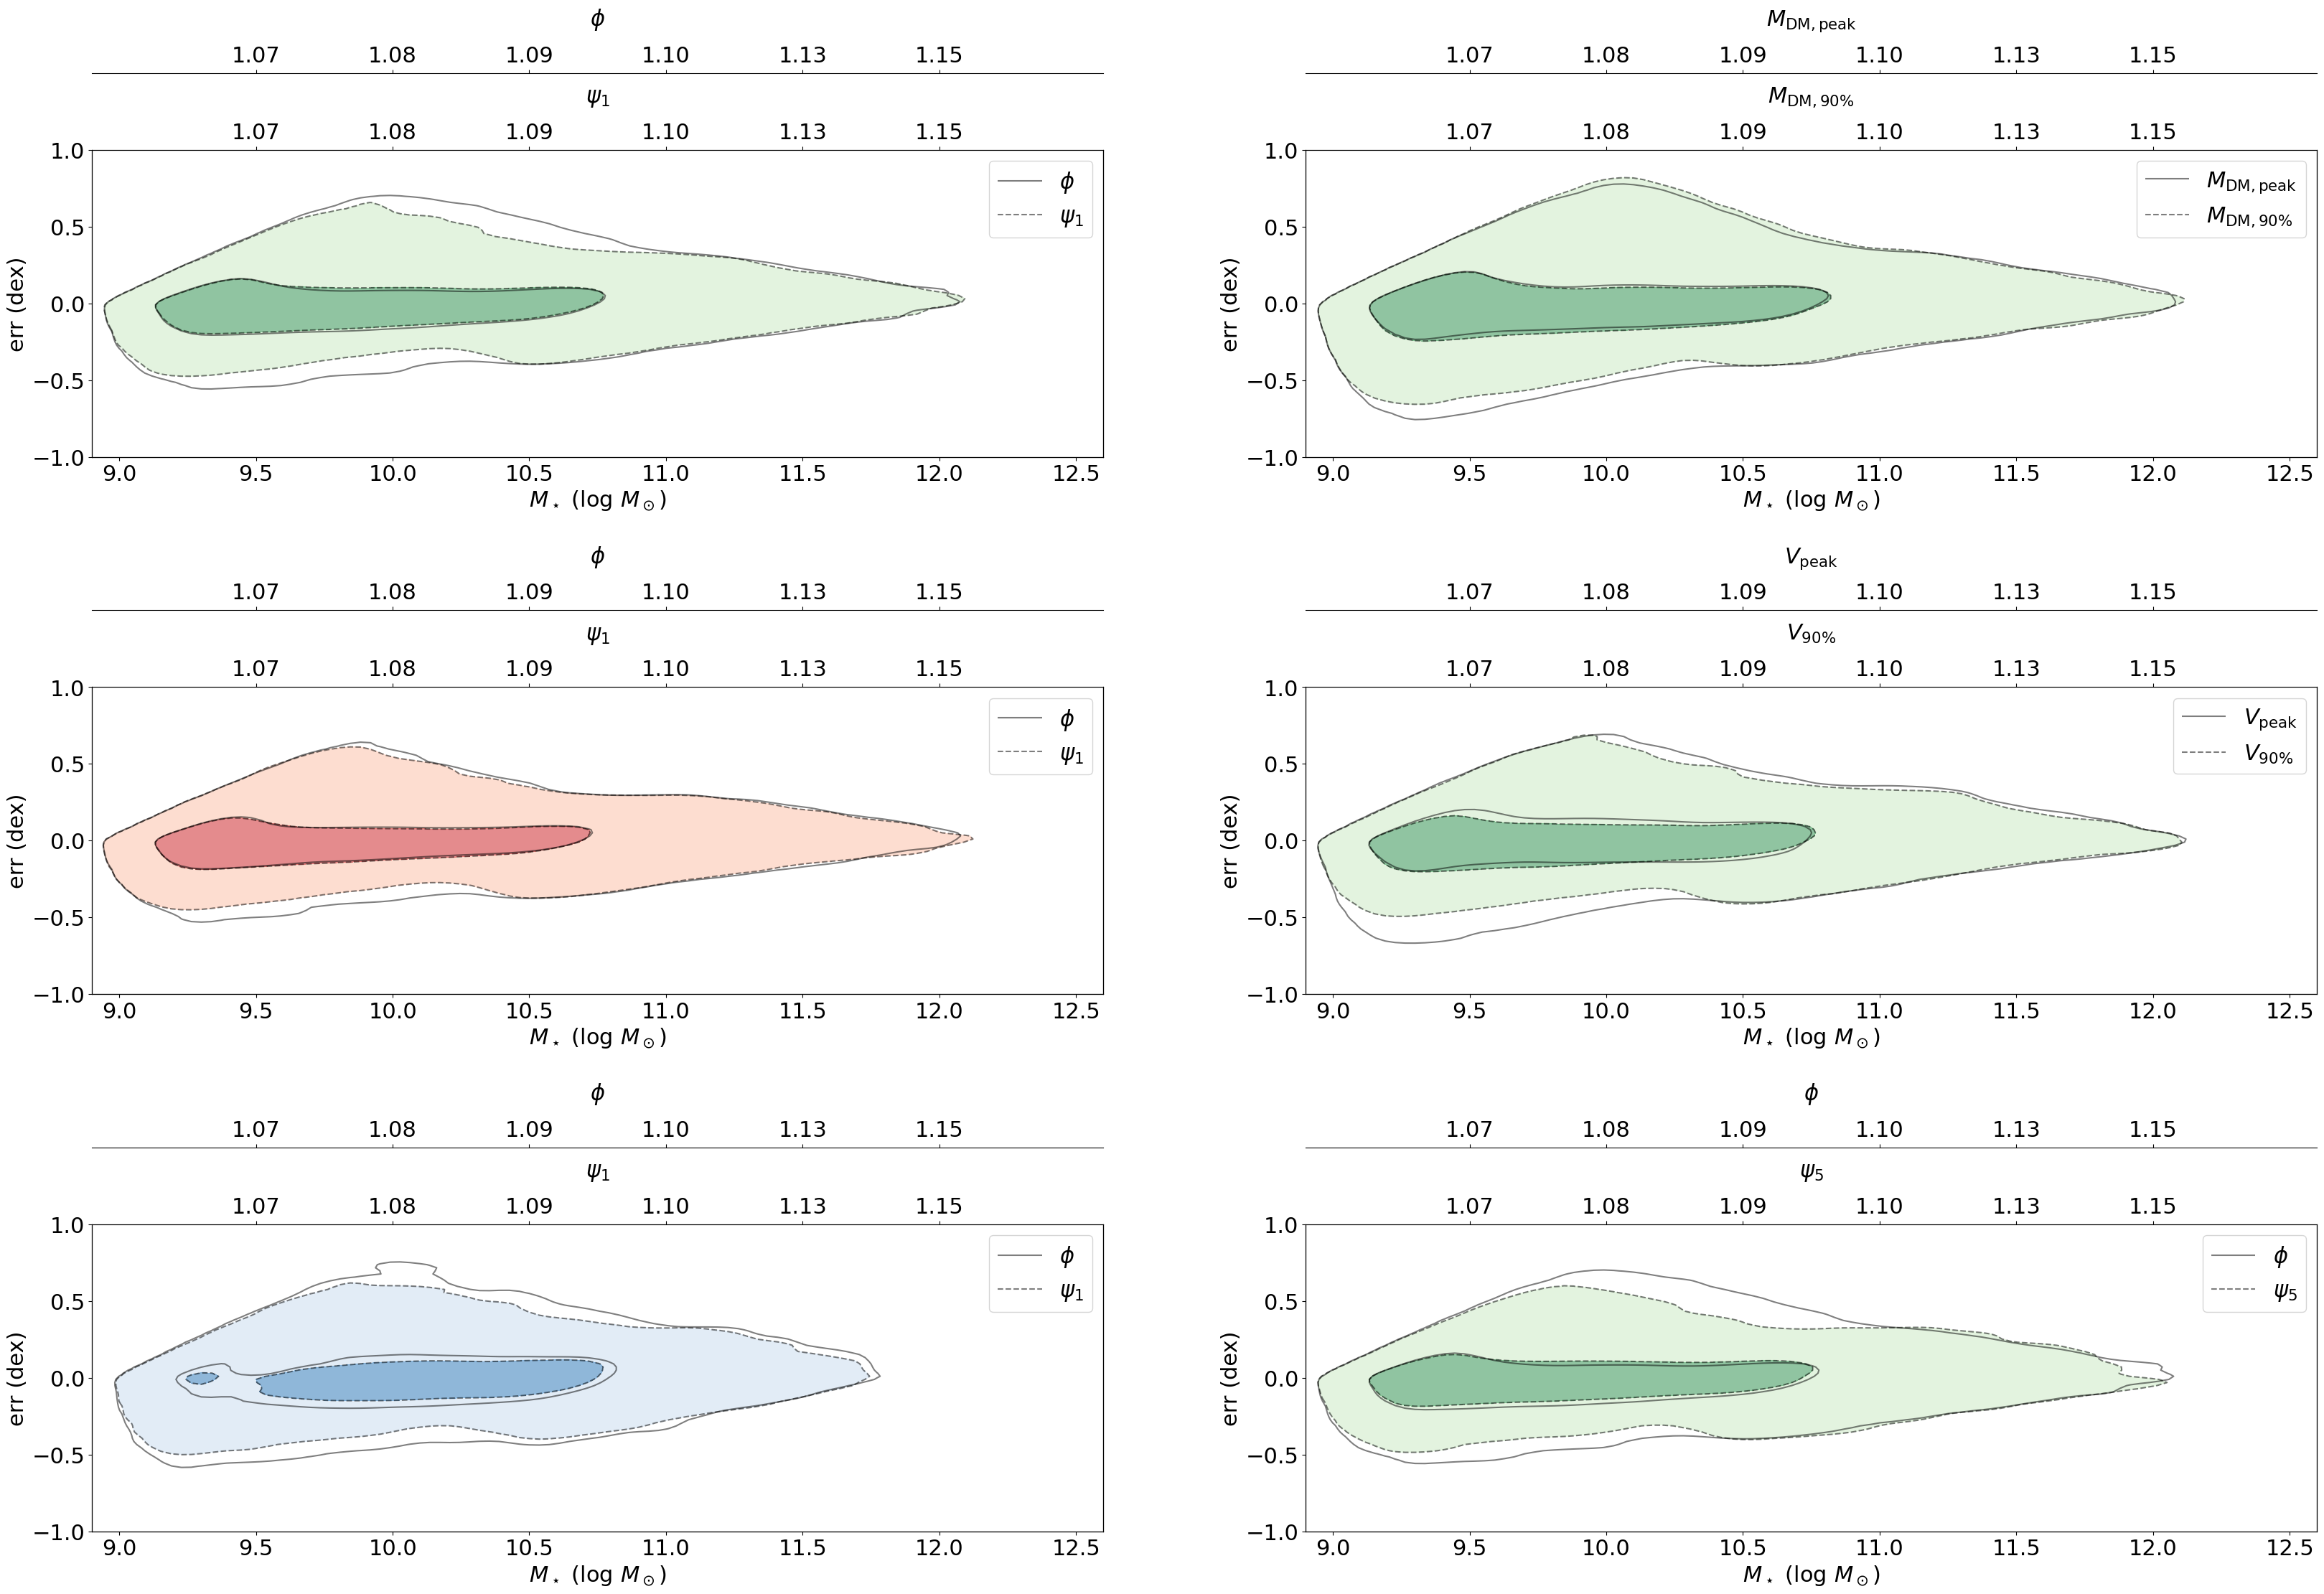

In [14]:
### Plot ###
xlims = [8.9, 12.6]
ylims = [-1.0, 1.0]
plot_nms = np.array([plot_nm.replace('\rm', '\\rm') for plot_nm in plot_nms])

plt_srt = np.array([[4, 7], [0, 1], [5, 8], [2, 3], [6, 9], [4, 10]])
col_mat = np.zeros((11), dtype=int)
col_mat[[1, 3, 7, 8, 9, 10]] = 1
cols = ['Greens', 'Reds', 'Blues']
fmts = ['solid', 'dashed']

plt.figure(figsize=(40, 25), dpi=100)
plt.subplots_adjust(hspace=0.75)

for i, poss in enumerate(plt_srt):
    ax = plt.subplot(3, 2, i+1)
    hs = []
    for pos in poss:
        cset = ax.contour(xxs[pos], yys[pos], fs[pos], colors='k', levels = [0.01, 0.5, 1.0], alpha=0.5, linestyles=fmts[col_mat[pos]])
        hs.append(cset.legend_elements()[0][0])
        axy = ax.twiny()
        axy.set_xticks(strticks[1:-1])
        axy.set_xticklabels(['{:.2f}'.format(i) for i in np.log10(sham_ticks[pos][1:-1])])
        axy.set_xlim(xlims)
        axy.set_xlabel(plot_nms[pos], labelpad=20)
        if col_mat[pos] == 1:
            ax.contourf(xxs[pos], yys[pos], fs[pos], cmap=cols[types[pos]], levels = [0.01, 0.5, 1.0], alpha=0.5, linestyles=fmts[col_mat[pos]])
            continue
        axy.spines.top.set_position(("axes", 1.25))
    ax.set_xlabel('$M_\star\ (\log\,M_\odot)$')
    ax.set_ylabel('err (dex)')
    ax.legend(hs, plot_nms[poss])
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    


## Projected 2PCFs
Compare the projected 2PCFs for different M*/color bins of hydro simulation and AMed DMO simulation

In [15]:
### For Jackknife uncertainty ###
orig = np.expand_dims(np.arange(len(SubhaloFeat_H_3[2])), axis=0)
shf = np.arange(len(SubhaloFeat_H_3[2]), dtype=int)
np.random.seed(0)
np.random.shuffle(shf)
shf_arrs = np.array_split(shf, 27, axis=0) # 27 Jacknife samples
shf_msk = np.zeros_like(SubhaloFeat_H_3[2])
for i, shf_arr in enumerate(shf_arrs):
    shf_msk[shf_arr] = i


In [16]:
### Calculate projected 2PCFs ###
def sham_clust(boxsize, # Simulation box size (302 Mpc)
               pimax, # 40 Mpc
               nthreads, # number of parallel threads
               rbins, # projected separation bins
               Pos, # position of each subhalo
               masks, # [Jackknife mask (randomly 0-(N-1) for N Jackknife samples), M* bin mask (0: galaxies not in the M* bin, 1: galaxies in the M* bin), color mask (0: red galaxies, 1: blue galaxies)]
               pops, # Galaxy poopulations (0: All, 1: Blue, 2: Red)
               str_pos=None, # The index array that sort the subhalos according to their stellar mass
               sham_pos = None, # The index array that sort the subhalos according to their subhalo features
               orig = False, # if True, calculate clustering of the original simulation box; if False, calculate clustering after AM
               return_kns = True): # if True, return clustering of each Jackknife tests
    ### Some explanations ###
    # 1. The masks mask out the subhalos that is not in the current M*/color bins
    # 2. We sort the position of subhalos according to the subhalo features
    # 3. The M* mask sorted by the M*: M* mask is assigned to the subhalo by AM, then M* dependent 2PCFs are calculated
    # 4. The color mask sorted by the subhalo features: We know the true color mask of the subhalos, so we're effectively doing AM of galaxies and subhalos with certain color. 
    # 
    
    ## subhalo positions ##
    X, Y, Z = Pos[:,0], Pos[:,1], Pos[:,2]
    if orig == True: # if calculate clustering of the original simulation box, make the str_pos and sham_pos the same
        sham_pos = str_pos = np.arange(len(X), dtype=int)
    X_srtsham, Y_srtsham, Z_srtsham = X[sham_pos], Y[sham_pos], Z[sham_pos] # sort subhalo positions according to the subhalo feature (true positions)
    
    ## masks ##
    if pops == 0: # if all galaxies
        shf_msk, str_mask = masks[0], masks[1]
        mask_tot_srtsham = str_mask[str_pos] # sort the M* mask according to the M* (assigned mask)
        #mask_tot_srtstr = np.logical_and(shf_msk[str_pos], str_mask[str_pos])
    elif pops == 1: # if blue galaxies
        shf_msk, str_mask, col_mask = masks[0], masks[1], masks[2]
        mask_tot_srtsham = np.logical_and(str_mask[str_pos], col_mask[sham_pos]) # sort the color mask according to the subhalo features (true mask)
        #mask_tot_srtstr = np.logical_and.reduce((shf_msk[str_pos], str_mask[str_pos], col_mask[str_pos]))
    elif pops == 2: # if red galaxies
        shf_msk, str_mask, col_mask = masks[0], masks[1], masks[2]
        mask_tot_srtsham = np.logical_and(str_mask[str_pos], ~col_mask[sham_pos]) # sort the color mask according to the subhalo features (true mask)
    
    ## Calculate projected 2PCFs ##
    results_wp = wp(boxsize, pimax, nthreads, rbins, X_srtsham[mask_tot_srtsham], Y_srtsham[mask_tot_srtsham], Z_srtsham[mask_tot_srtsham], output_rpavg=True)
    rp = results_wp['rpavg'] # rp
    wpp = results_wp['wp'] # wp
    
    ## Jackknife resampling ##
    wp_kns = []
    for kn in range(np.max(shf_msk)+1):
        mask_tot_shf = np.logical_and(mask_tot_srtsham, shf_msk!=kn) # randomly remove one Jackknife sample
        results_wp = wp(boxsize, pimax, nthreads, rbins, X_srtsham[mask_tot_shf], Y_srtsham[mask_tot_shf], Z_srtsham[mask_tot_shf], output_rpavg=False) # calculate projected 2PCF
        wp_kn = results_wp['wp'] # output wp of each Jackknife test
        wp_kns.append(wp_kn)
        if kn == 0:
            wp_err = (wpp-wp_kn)**2
        elif kn > 0:
            wp_err += (wpp-wp_kn)**2
    wp_err = np.sqrt(26/27*wp_err) # calculate Jackknife error
    if return_kns == False:
        return rp, wpp, wp_err
    elif return_kns == True:
        return rp, wpp, wp_err, wp_kns
    

Text(0.5, 0, 'g (mag)')

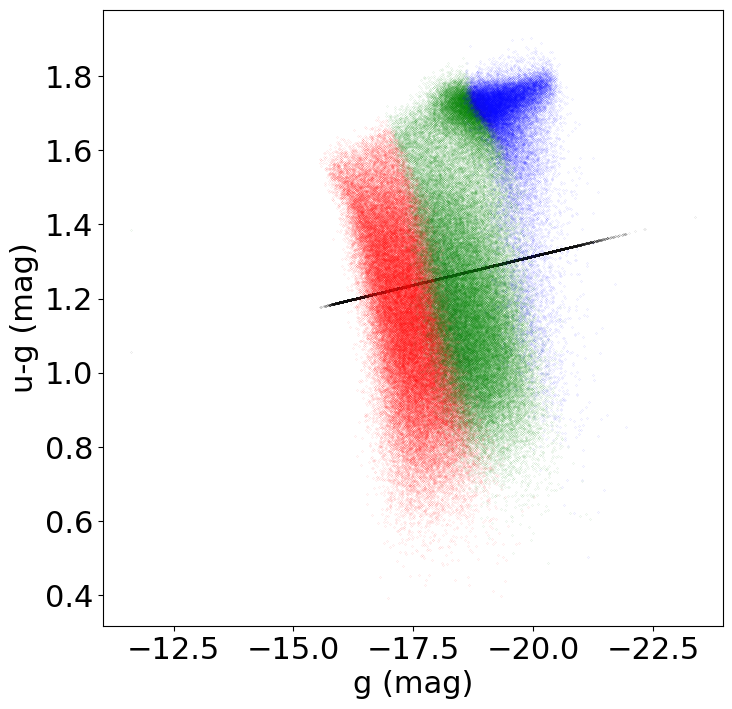

In [17]:
### CMD ###
# color: each M* bin
# black line: color cut

plt.figure(figsize=(8, 8))
plt.plot(SDSS_phot_3_g, -0.031*SDSS_phot_3_g-0.065*z+0.695, 'k.', alpha=1, markersize=0.1)
mbins = 10**np.array([9, 9.8, 10.6, 11.5])
cols = ['r.', 'g.', 'b.']
for i in range(len(mbins)-1):
    flg = np.logical_and(SubhaloMassType_str_3>=mbins[i], SubhaloMassType_str_3<=mbins[i+1])
    plt.plot(SDSS_phot_3_g[flg], SDSS_phot_3_ug[flg], cols[i], alpha=1, markersize=0.1)
plt.gca().invert_xaxis()
plt.ylabel('u-g (mag)')
plt.xlabel('g (mag)')

In [18]:
### calculate wps ###
boxsize = 302.6/(1+z) # TNG300 box size
nthreads = 64 # number of parallel threads
rmin = 0.1/h # minimum rp bin wall
rmax = 20.0/h # maximum rp bin wall
nbins = 12 # number of rp bins
rbins = np.logspace(np.log10(rmin), np.log10(rmax), nbins + 1) # create rp grids
pimax = 40.0/(1+z) # pi
mbins = 10**np.array([9, 9.8, 10.6, 11.5]) # M* grid
Pos = SubhaloPos_D_3/1e6/(1+z) # galaxy position of hydro simulation
Pos_H = SubhaloPos_H_3/1e6/(1+z) # subhalo position of DMO simulation

wppsss = [] # all wps
rpsss = [] # all rps 
wp_knssss = [] # all Jackkinfed wps

for k in range(3): # for each population (all/red/blue)
    wppss = []
    rpss = []
    wp_knsss = []

    for i in range(len(mbins)-1): # for each M* bin
        ## create masks ##
        masks = [
            shf_msk, # Jackknife mask
            np.logical_and(mbins[i] <= SubhaloMassType_str_3, SubhaloMassType_str_3 <= mbins[i+1]), # M* bin mask
            -0.031*SDSS_phot_3_g-0.065*z+0.695-SDSS_phot_3_ug > 0 # color mask
        ]
        
        ## Original wps ##
        wpps = []
        rps = []
        wp_knss = []
        pops = 0 
        orig = True
        # DMO #
        rp_D, wpp_D, wp_err_D, wp_kns_D = sham_clust(boxsize, pimax, nthreads, rbins, Pos, masks, pops=k, orig = orig, return_kns = True)
        wpps.append(wpp_D)
        rps.append(rp_D)
        wp_knss.append(wp_kns_D)
        
        # Hydro #
        rp_H, wpp_H, wp_err_H, wp_kns_H = sham_clust(boxsize, pimax, nthreads, rbins, Pos_H, masks, pops=k, orig = orig, return_kns = True)
        wpps.append(wpp_H)
        rps.append(rp_H)
        wp_knss.append(wp_kns_H)

        ## AMed wps ##
        # single component AM schemes #
        orig = False
        for j, (comp1, comp_peak) in enumerate(zip(comp1s, comp_peaks)):
            comps = [comp_peak]
            loss, std, sham_pos, str_pos = sham(PeakSubhaloMassType_DM_D_3, comps, SubhaloMassType_str_3, 0, pop_flag, False, return_err=False, return_pos=True) # AM
            rp, wpp, wp_err, wp_kns = sham_clust(boxsize, pimax, nthreads, rbins, Pos, masks, pops=k, str_pos=str_pos, sham_pos=sham_pos, orig = orig, return_kns = True) # AMed wp
            wpps.append(wpp)
            rps.append(rp)
            wp_knss.append(wp_kns)

            comps = [comp1[pt_pos[j]]]
            loss, std, sham_pos, str_pos = sham(PeakSubhaloMassType_DM_D_3, comps, SubhaloMassType_str_3, 0, pop_flag, False, return_err=False, return_pos=True)
            rp, wpp, wp_err, wp_kns = sham_clust(boxsize, pimax, nthreads, rbins, Pos, masks, pops=k, str_pos=str_pos, sham_pos=sham_pos, orig = orig, return_kns = True)
            wpps.append(wpp)
            rps.append(rp)
            wp_knss.append(wp_kns)
        
        # two-component AM schemes #
        comps = [SubhaloVmax_D_3, PeakSubhaloMassType_DM_D_3]
        loss, std, sham_pos, str_pos = sham(PeakSubhaloMassType_DM_D_3, comps, SubhaloMassType_str_3, 0, pop_flag, True, norm_origin, return_err=False, return_pos=True)
        rp_phi, wpp_phi, wp_err_phi, wp_kns_phi = sham_clust(boxsize, pimax, nthreads, rbins, Pos, masks, pops=k, str_pos=str_pos, sham_pos=sham_pos, orig = orig, return_kns = True)
        wpps.append(wpp_phi)
        rps.append(rp_phi)
        wp_knss.append(wp_kns_phi)

        for norm_pos, ij in enumerate(edge_index):
            comps = [comp1s[ij[0]][pt_pos[ij[0]]], comp1s[ij[1]][pt_pos[ij[1]]]]
            loss, std, sham_pos, str_pos = sham(PeakSubhaloMassType_DM_D_3, comps, SubhaloMassType_str_3, 0, pop_flag, True, norm_ats[norm_pos], return_err=False, return_pos=True)
            rp, wpp, wp_err, wp_kns = sham_clust(boxsize, pimax, nthreads, rbins, Pos, masks, pops=k, str_pos=str_pos, sham_pos=sham_pos, orig = orig, return_kns = True)
            wpps.append(wpp)
            rps.append(rp)
            wp_knss.append(wp_kns)

        wppss.append(wpps)
        rpss.append(rps)
        wp_knsss.append(wp_knss)
        
    wppsss.append(wppss)
    rpsss.append(rpss)
    wp_knssss.append(wp_knsss)

wppsss = np.array(wppsss)
wp_knssss = np.array(wp_knssss)
rpsss = np.array(rpsss)
wppsss.shape, wp_knssss.shape


((3, 3, 19, 12), (3, 3, 19, 27, 12))

In [19]:
### Calculate metrics between orginal and AMed wps ###
## percentage difference ##
rpsss_cp = np.copy(rpsss[:,:,2:])
wpsham_diff = np.abs(wppsss[:,:,1:2] - wppsss[:,:,2:])/wppsss[:,:,1:2] # 1:2 for hydro, 0:1 for DMO (don't use this)
wpsham_diff_kns = np.abs(wp_knssss[:,:,1:2] - wp_knssss[:,:,2:])/wp_knssss[:,:,1:2]
wpsham_diff_err = np.sqrt(np.sum((np.expand_dims(wpsham_diff, axis=3) - wpsham_diff_kns)**2, axis=3)*26/27)

## ratio of AMed/original wps ##
wpsham_rat = wppsss[:,:,2:]/wppsss[:,:,1:2]
wpsham_rat_kns = wp_knssss[:,:,2:]/wp_knssss[:,:,1:2]
wpsham_rat_err = np.sqrt(np.sum((np.expand_dims(wpsham_rat, axis=3) - wpsham_rat_kns)**2, axis=3)*26/27)

## filter out the wps with percentage difference Jackknife error >= 0.2 (20%) ##
flg_1 = np.logical_or(rpsss_cp==0.0, wpsham_diff_err>=0.2)
#print(np.where(wpsham_diff_err>=0.05))
wpsham_diff[flg_1] = np.nan
wpsham_rat[flg_1] = np.nan
wpsham_rat_err[flg_1] = np.nan
wpsham_diff_err[flg_1] = np.nan
rpsss_cp[flg_1] = np.nan


/tiara/home/cychuang/.conda/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


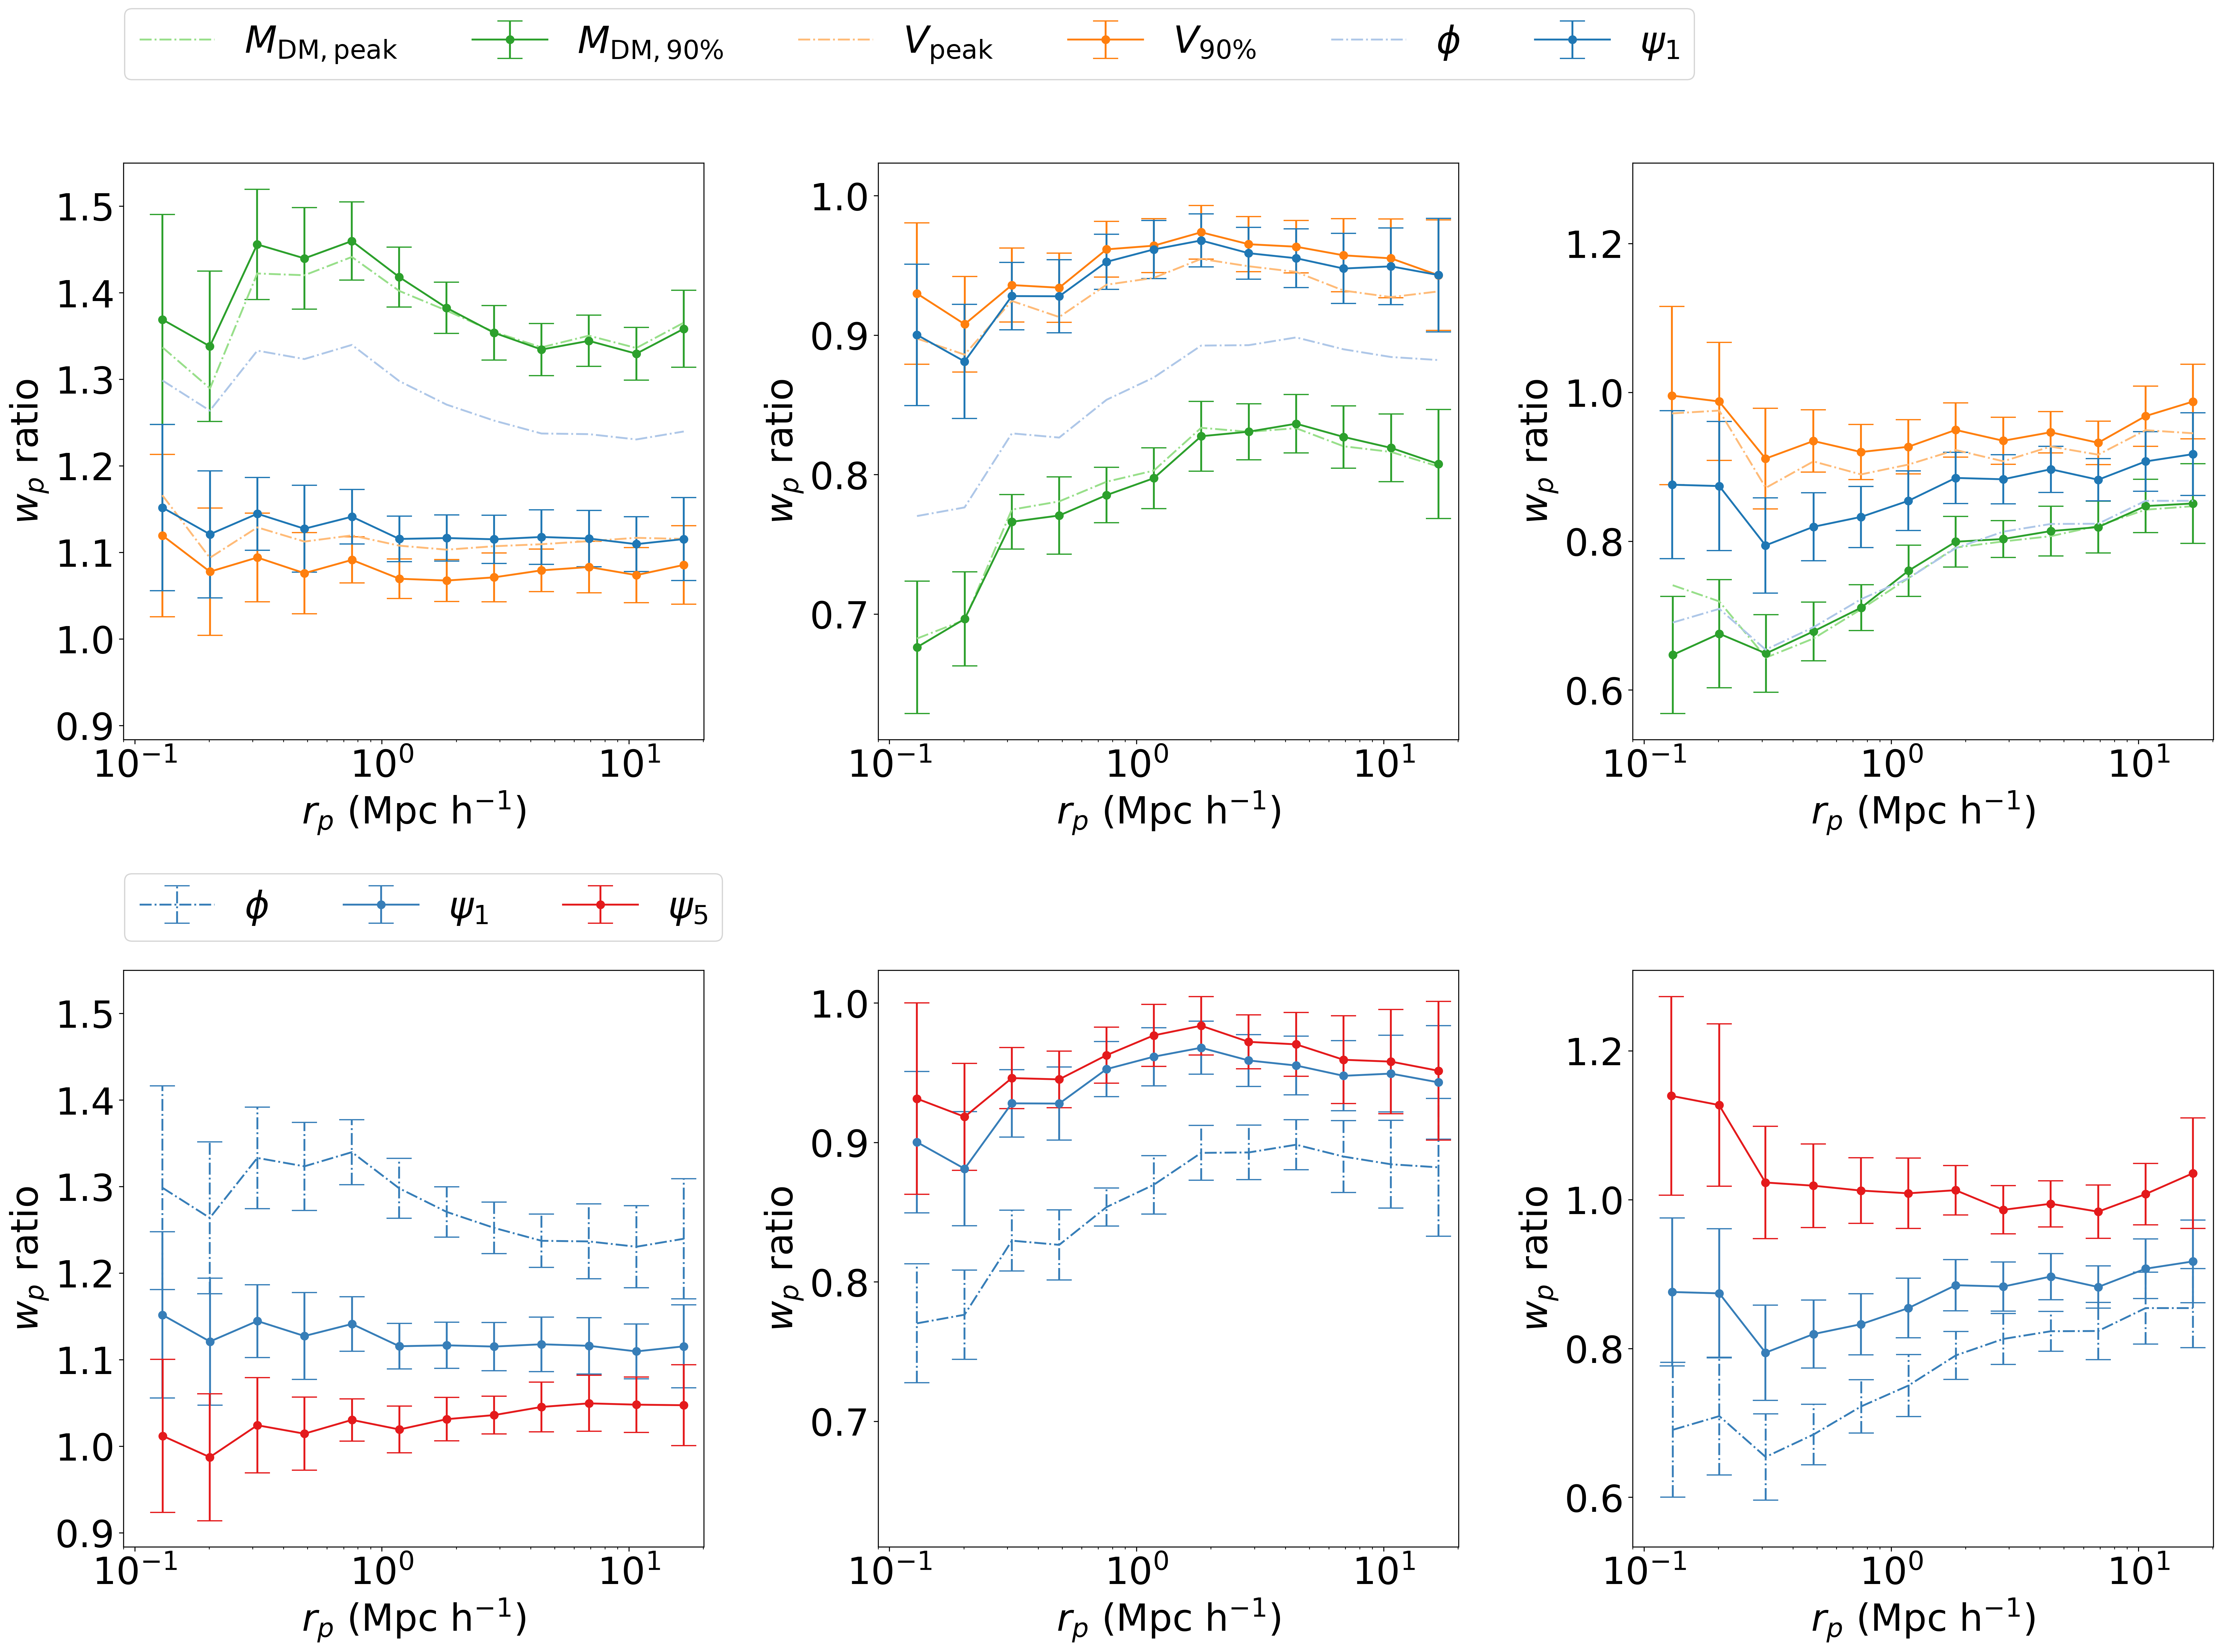

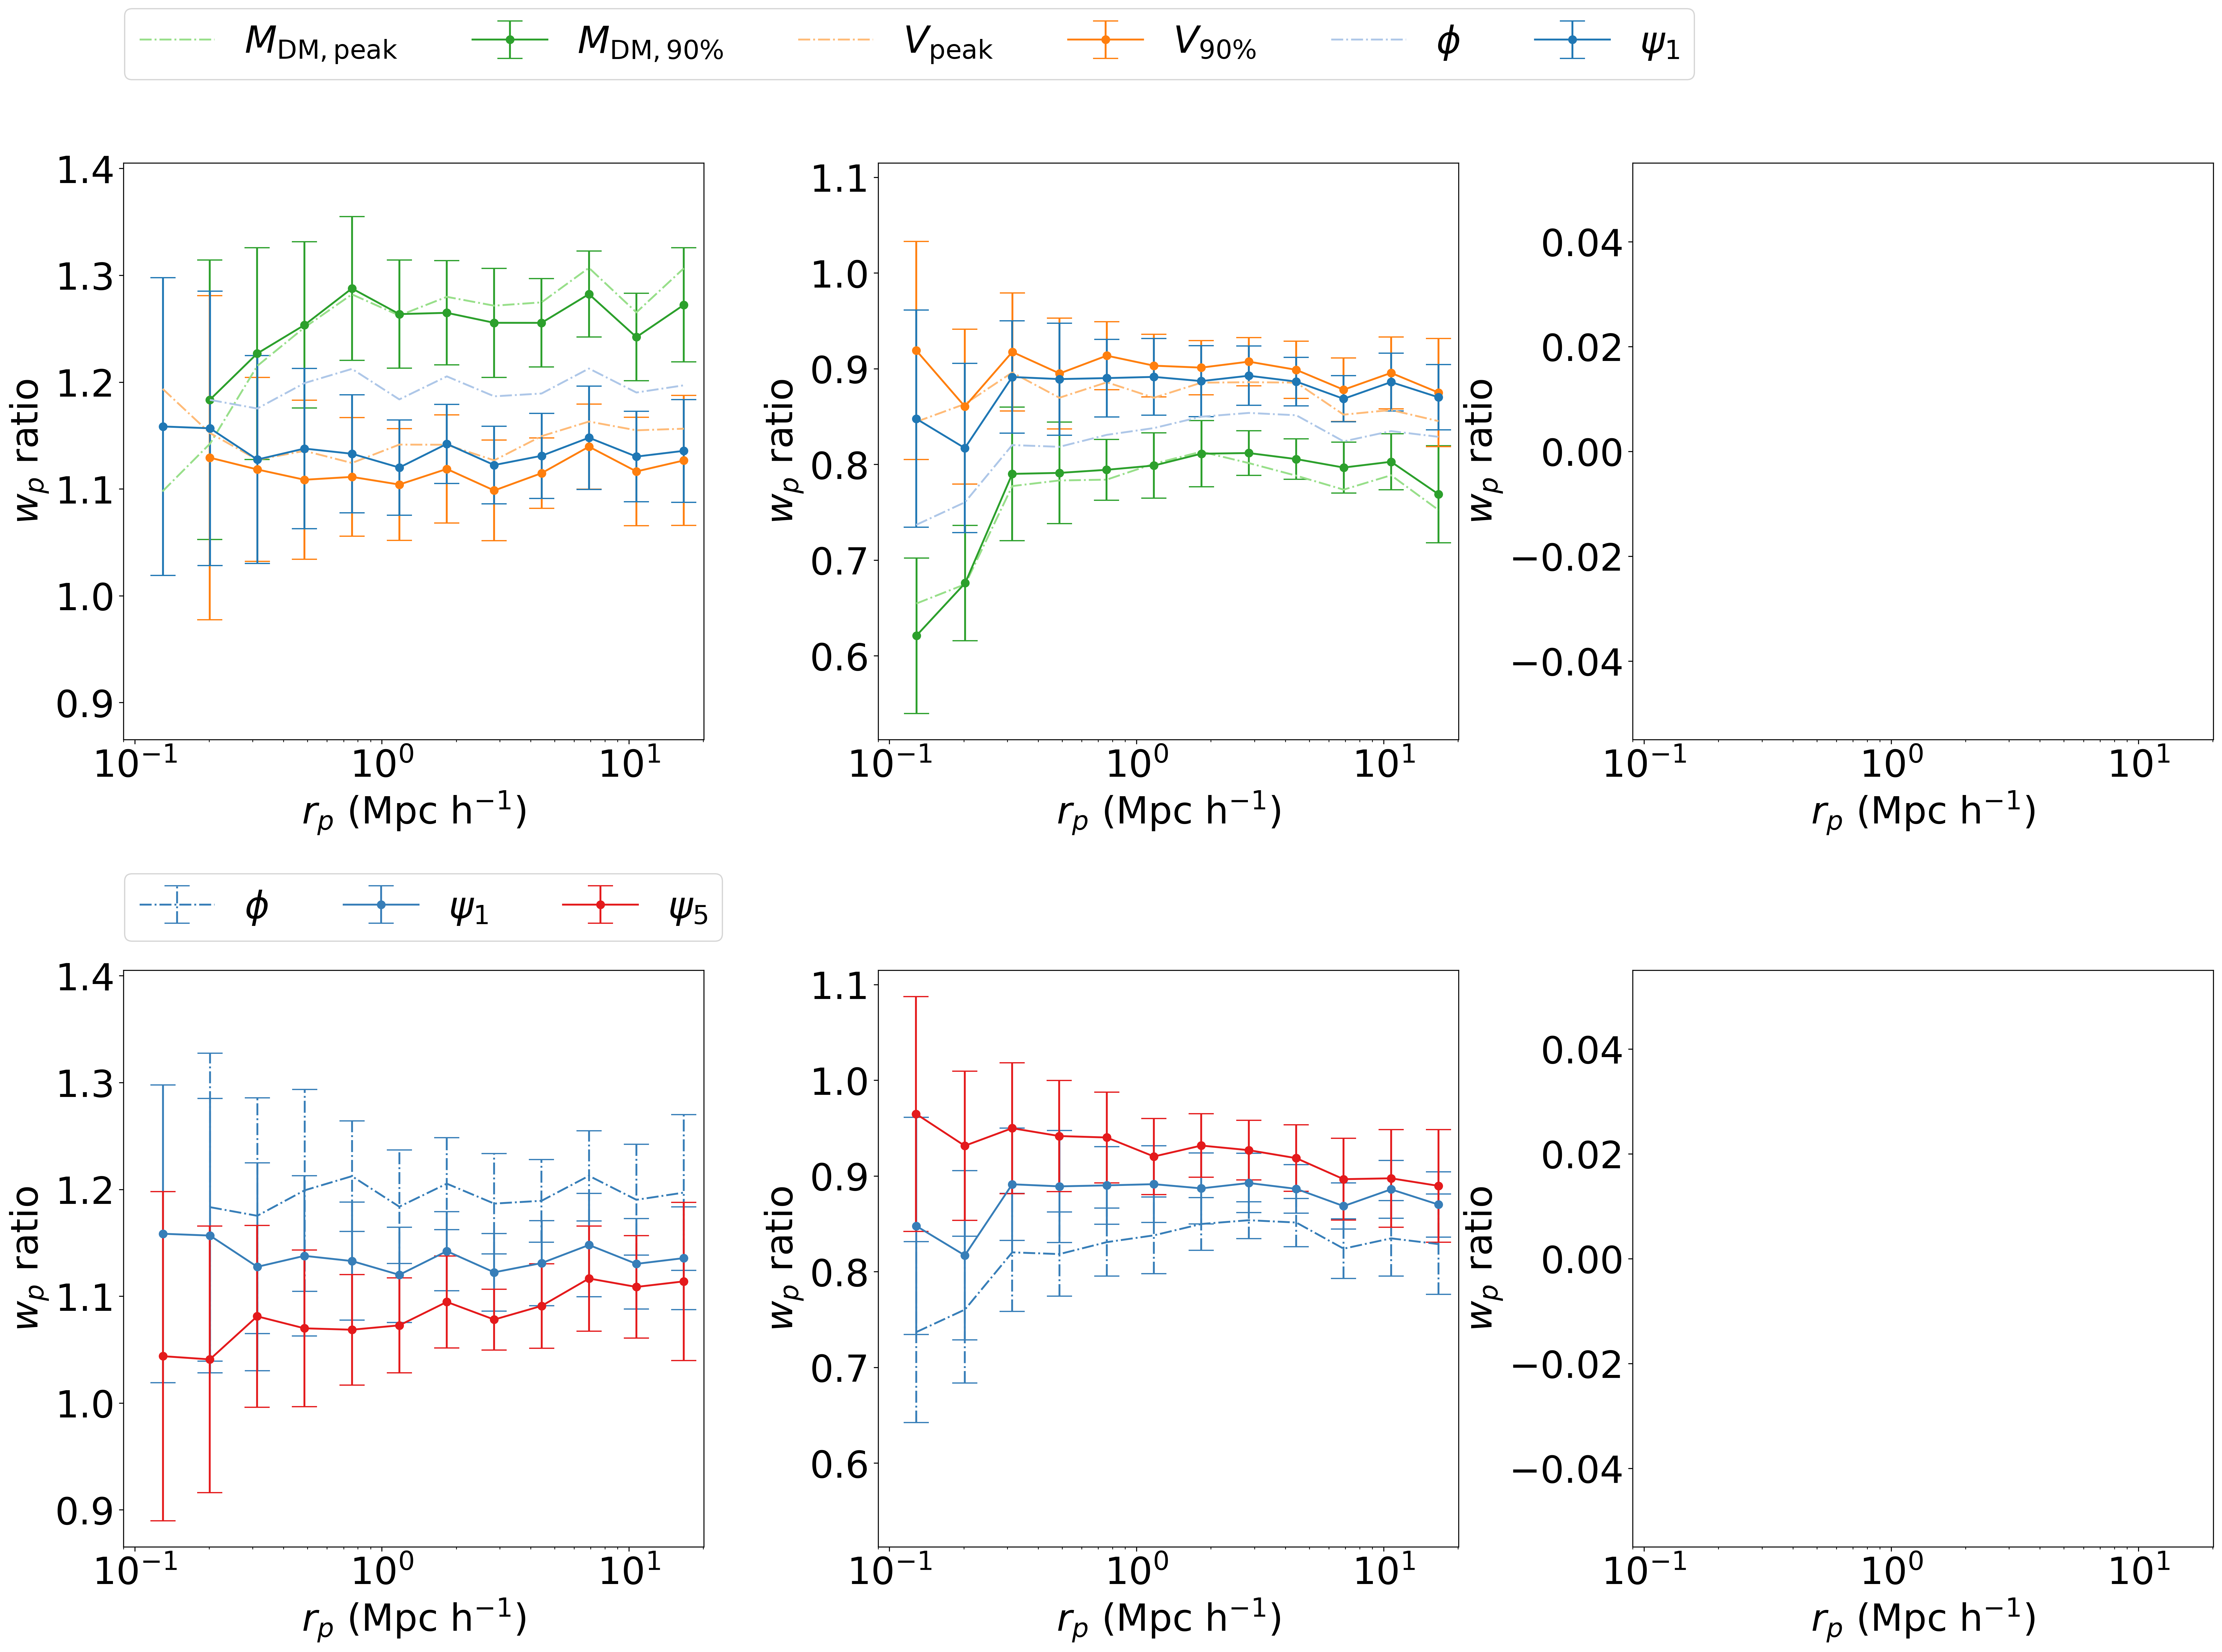

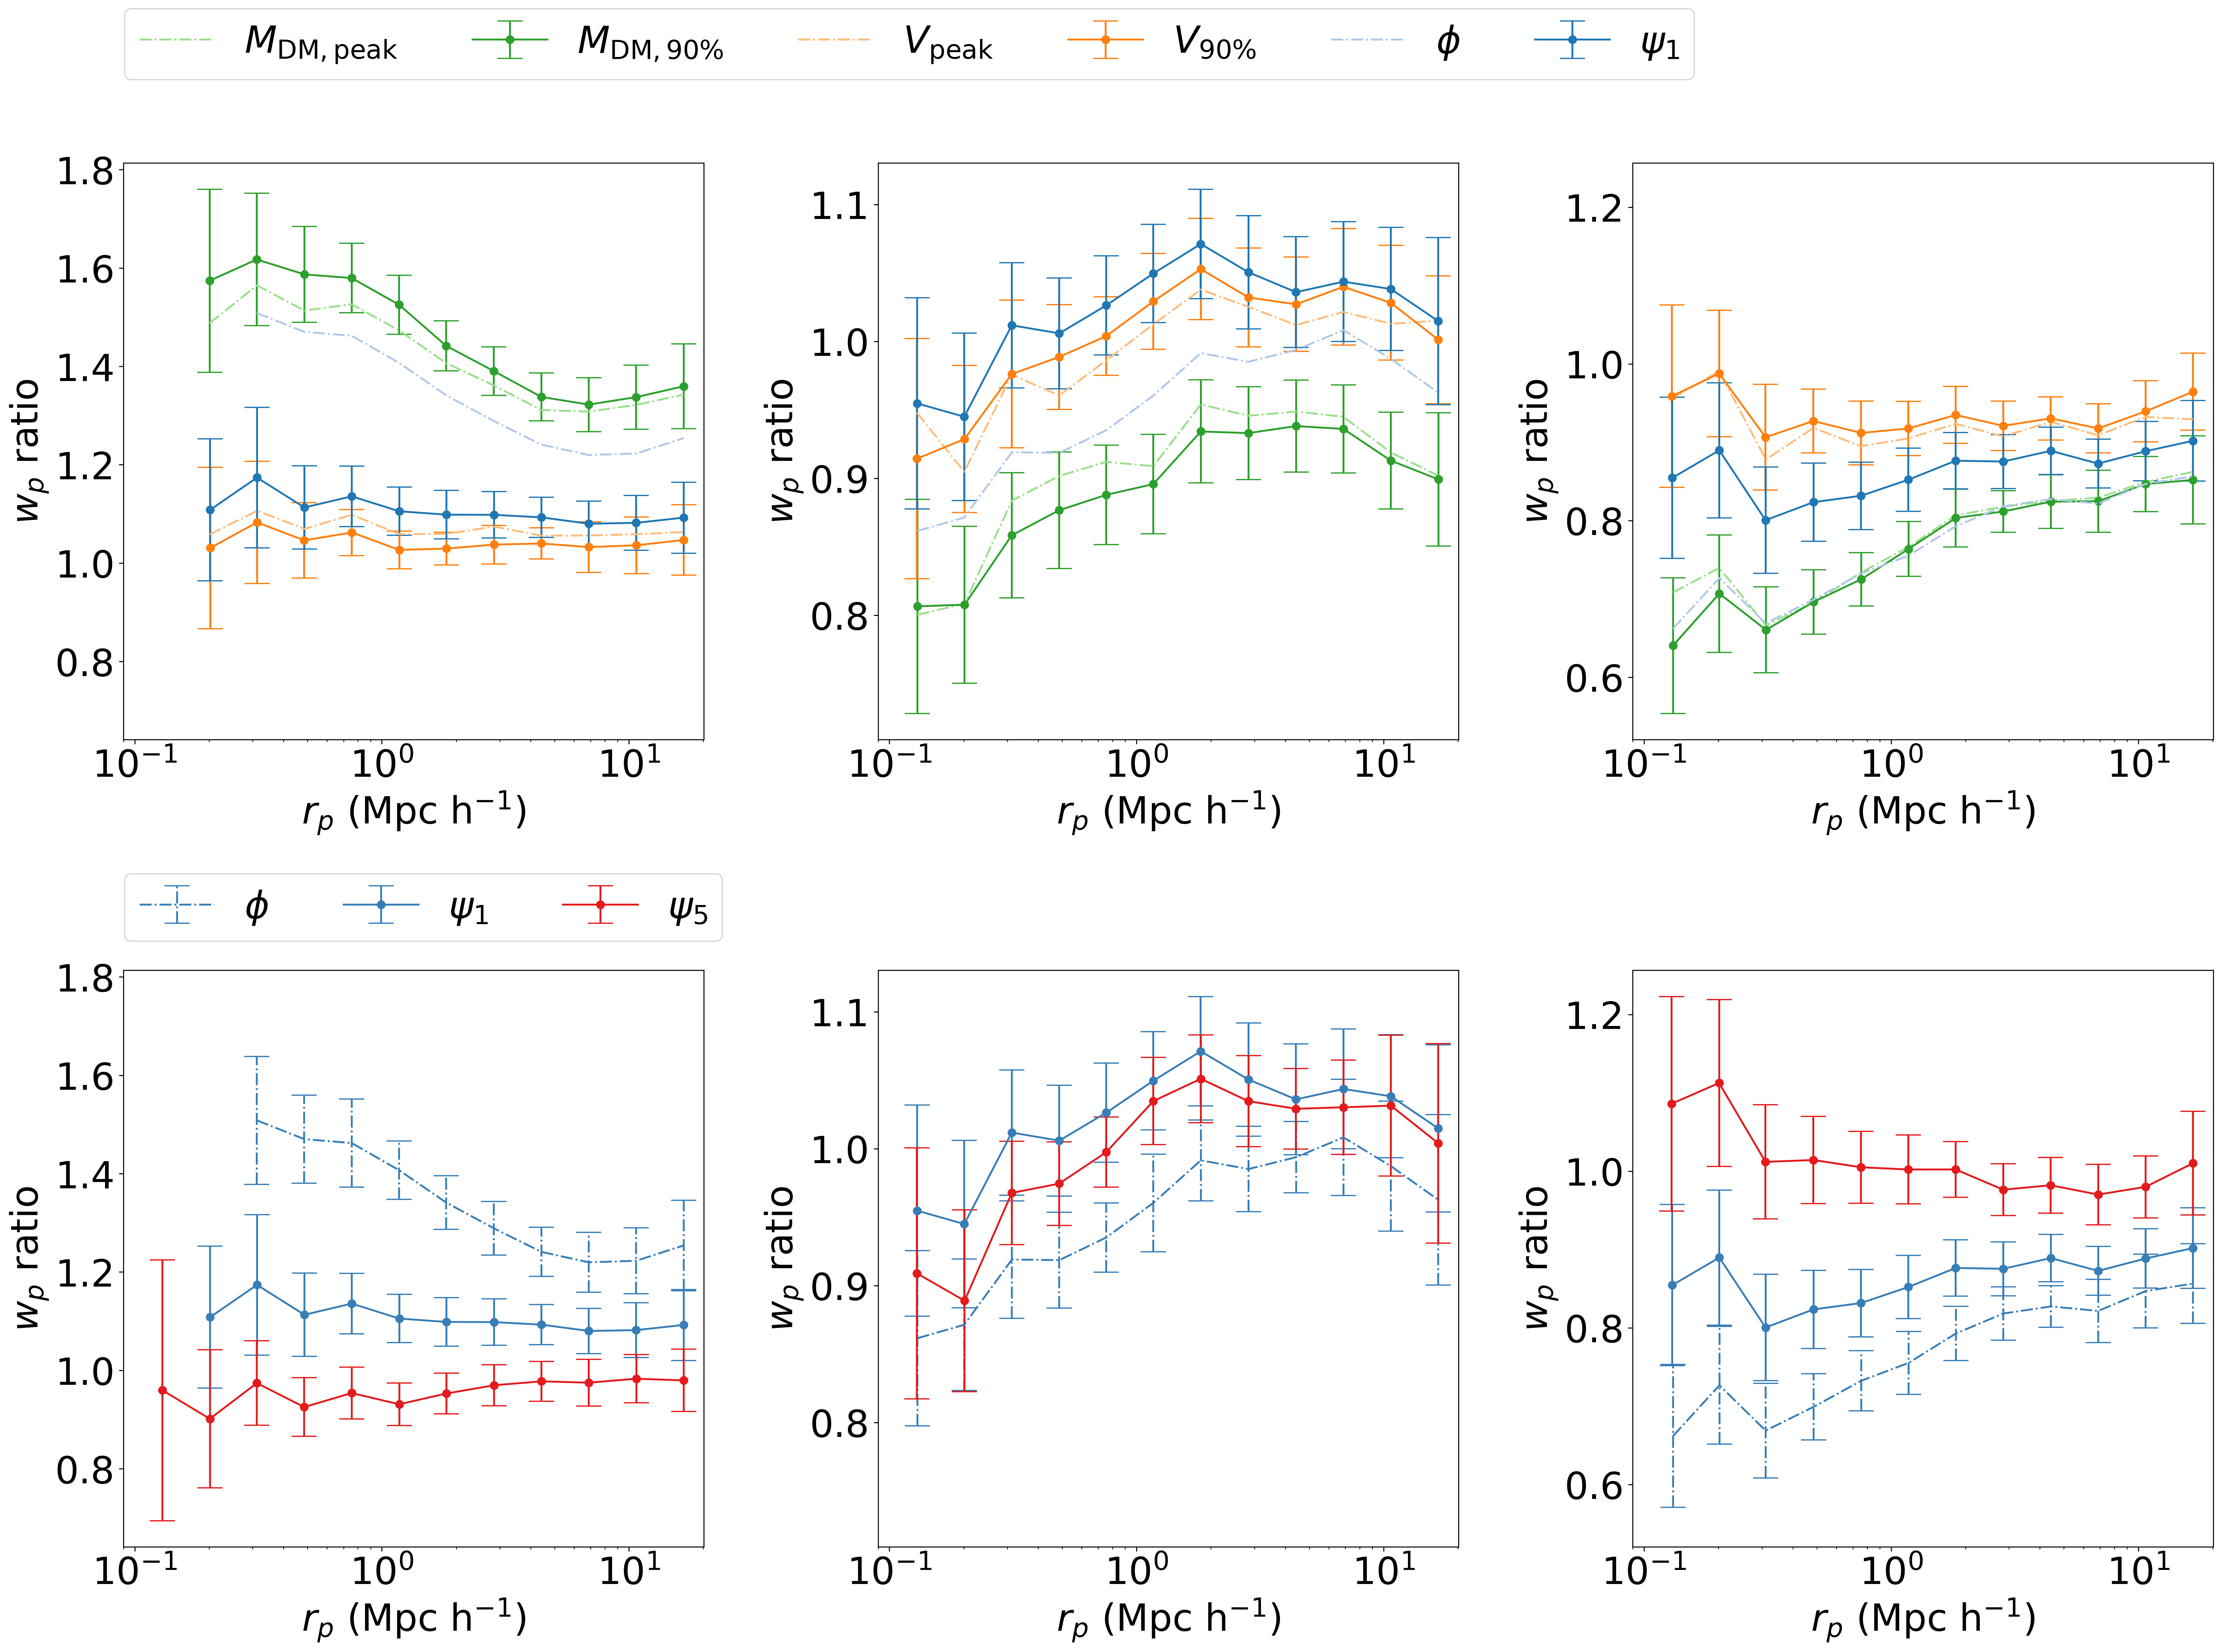

In [22]:
### Make Plots ###
plot_nms = np.array([plot_nm.replace('\rm', '\\rm') for plot_nm in names])
plt_pos = [0, 1, 6, 7, 10, 11, 10, 11, 15]
fmts = ['-.', 'o-']
fmts_err = ['-.', '-']
alphas = [0, 1]
cmap = matplotlib.cm.get_cmap('tab20')
col1 = cmap(np.flip(np.linspace(0.025, 0.975, 20)))[[-6, -5, -4, -3, -2, -1]]
cmap = matplotlib.cm.get_cmap('Set1')
col2 = cmap(np.flip(np.linspace(0.025, 0.975, 20)))[[-4, -3, -1]]
col = np.concatenate((col1, col2), axis=0)
for cb in range(3):
    #cb = 2
    plt.rcParams.update({'font.size': 30})
    fig, axs = plt.subplots(2, 3, figsize=(30, 20), dpi=300)
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    for j in range(len(mbins)-1):
        for i in range(6):
            rps = rpsss_cp[cb,j,plt_pos[i]]
            wp_rats = wpsham_rat[cb,j,plt_pos[i]]
            wp_rat_errs = wpsham_rat_err[cb,j,plt_pos[i]]
            if np.sum(np.isnan(wp_rats))>0:
                flg = np.argmax(np.where(np.isnan(wp_rats))[0])
                wp_rats[:flg+1] = np.nan
                wp_rat_errs[:flg+1] = np.nan
            eb, caps, bars = axs[0][j].errorbar(rps*h, wp_rats, yerr = wp_rat_errs, fmt=fmts[plt_pos[i]%2], color=col[i], capsize=10)
            [bar.set_alpha(alphas[plt_pos[i]%2]) for bar in bars]
            [cap.set_alpha(alphas[plt_pos[i]%2]) for cap in caps]
            axs[1][j].errorbar(rpsss_cp[cb,j,plt_pos[i]]*h, wpsham_rat[cb,j,plt_pos[i]], yerr = wpsham_rat_err[cb,j,plt_pos[i]], fmt=fmts[plt_pos[i]%2], color=col[i], capsize=10, alpha=0.0, label='')
        axs[0][j].set_xscale('log')
        if j == 0:
            axs[0][j].legend(plot_nms[plt_pos[:6]], ncol=6, loc='upper left', bbox_to_anchor=(-0.03,1.3))
        axs[0][j].set_xlim(0.09, 20.1)
        axs[0][j].set_xlabel('$r_p$ (Mpc $\\rm h^{-1}$)')
        axs[0][j].set_ylabel('$w_p$ ratio')
        #axs[0][j].set_title('$M_*=10^{'+str(np.log10(mbins[j]))+'}-10^{'+str(np.log10(mbins[j+1]))+'}$',y=1.02)
        for i in range(6, 9):
            rps = rpsss_cp[cb,j,plt_pos[i]]
            wp_rats = wpsham_rat[cb,j,plt_pos[i]]
            wp_rat_errs = wpsham_rat_err[cb,j,plt_pos[i]]
            if np.sum(np.isnan(wp_rats))>0:
                flg = np.argmax(np.where(np.isnan(wp_rats))[0])
                wp_rats[:flg+1] = np.nan
                wp_rat_errs[:flg+1] = np.nan
            eb = axs[1][j].errorbar(rpsss_cp[cb,j,plt_pos[i]]*h, wpsham_rat[cb,j,plt_pos[i]], yerr = wpsham_rat_err[cb,j,plt_pos[i]], fmt=fmts[plt_pos[i]%2], color=col[i], capsize=10, label=plot_nms[plt_pos[i]])
            eb[-1][0].set_linestyle(fmts_err[plt_pos[i]%2])
            axs[0][j].errorbar(rps*h, wp_rats, yerr = wp_rat_errs, fmt=fmts[plt_pos[i]%2], color=col[i], capsize=10, alpha=0.0)
        axs[1][j].set_xscale('log')
        if j == 0:
            axs[1][j].legend(ncol=3, loc='upper left', bbox_to_anchor=(-0.03,1.2))#plot_nms[plt_pos[6:9]])
        axs[1][j].set_xlim(0.09, 20.1)
        axs[1][j].set_xlabel('$r_p$ (Mpc $\\rm h^{-1}$)')
        axs[1][j].set_ylabel('$w_p$ ratio')
        
        

In [21]:
### Display loss metrics ###
wpsham_differr = np.concatenate((np.nanmean(wpsham_diff, axis=(1,3)), np.nanmean(wpsham_diff_err, axis=(1,3))), axis=0).T

pd.options.display.float_format = '{:,.1f}'.format
df = pd.DataFrame(
    wpsham_differr*100, 
    columns = ['All','Blue','Red','All Error','Blue Error','Red Error'],
    index=names
)
df1 = pd.DataFrame({c: df.filter(like=c).applymap(lambda x: '{0:.1f}'.format(x)).apply('±'.join, 1) for c in df.columns.str[:3].unique()})
display(df1)

np.save(outdir+'/Clust_err_sn'+str(snap_num)+'.npy', wpsham_differr*100)


All       Blu       Red
$M_{\rm DM,peak}$                27.3±4.1  24.0±6.2  24.2±5.6
$M_{\rm DM,90\%}$                28.0±4.0  24.0±5.3  26.4±5.6
$M_{\rm R_{max},peak}$           21.2±3.8  24.2±7.0  16.5±5.4
$M_{\rm R_{max},80\%}$           19.3±3.9  18.8±6.2  15.8±5.6
$|\dot{M_{\rm DM}}|_{\rm peak}$   7.7±3.8  15.3±7.6   7.6±5.8
$|\dot{M_{\rm DM}}|_{\rm 60\%}$   9.3±4.3   7.1±5.9  13.5±5.4
$V_{\rm peak}$                    8.8±3.9  13.9±6.0   5.9±5.1
$V_{\rm 90\%}$                    6.1±3.8  11.0±5.6   4.7±5.1
$V_{\rm disp,peak}$               8.6±4.0  13.8±6.2   5.6±5.4
$V_{\rm disp,80\%}$               6.2±4.1  11.4±6.3   4.3±5.0
$\phi$                           21.9±4.3  18.6±5.6  20.1±5.3
$\psi_1$                         10.5±4.0  13.0±5.7   9.4±5.6
$\psi_2$                          9.3±4.0  12.8±5.4   7.7±5.3
$\psi_3$                          8.0±4.1  11.6±6.3   6.9±5.3
$\psi_4$                          7.2±4.0  12.2±6.0   5.6±5.3
$\psi_5$                          3.7±4.2   7.8±6.0   3.7±5.6
$\psi_6$                          4.3±4.1   8.8±5.9   3.3±4.9

In [23]:
display(df.style.highlight_min())